In [1]:
import sys
sys.path.append('/global/u2/j/jianyao/PySM_public/')

In [2]:
from pysm.common import convert_units

In [3]:
import pysm3
import pysm3.units as u
from astropy.io import fits as fits
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean

%config Completer.use_jedi = False
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Config

In [5]:
## SPASS CBASS WMAP K, Planck 30, WMAP Ka

fres = np.array([2.3, 5, 23, 28.4, 33]); Nside = 32; 

nu0_both = gmean(fres)
nu0_C = gmean([fres[1], fres[2], fres[3], fres[4]])
nu0_S = gmean([fres[0], fres[2], fres[3], fres[4]])

# Foregrounds

## IQU at 5 fres

https://github.com/galsci/pysm/blob/f36aeaef51e5d449fb0bf20b40e4270d6867e14f/pysm3/data/presets.cfg

[s0]

class = "PowerLaw"

map_I = "pysm_2/synch_t_new.fits"

map_Q = "pysm_2/synch_q_new.fits"

map_U = "pysm_2/synch_u_new.fits"

unit_I = "uK_RJ"

unit_Q = "uK_RJ"

unit_U = "uK_RJ"

map_pl_index = -3

freq_ref_I = "408 MHz"

freq_ref_P = "23 GHz"


In [6]:
sky = pysm3.Sky(nside=Nside, preset_strings=["s0"])
maps_all = np.ones((len(fres), 3, 12*Nside**2)); maps_RJ = np.ones((len(fres), 3, 12*Nside**2))
for i in range(len(fres)):
    maps = sky.get_emission([fres[i]] * u.GHz)
    maps_RJ[i] = maps
#     maps_all[i] = maps.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(fres[i]*u.GHz))

In [11]:
(2.3/5)**(-3)

10.273691131749818

In [12]:
maps_RJ[0][1]/maps_RJ[1][1]

array([10.27369122, 10.27369082, 10.27369175, ..., 10.27369126,
       10.27369103, 10.27369134])

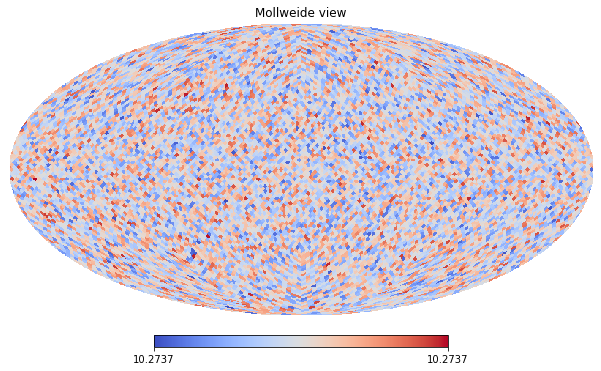

In [8]:
hp.mollview(maps_RJ[0][0]/maps_RJ[1][0], cmap = 'coolwarm')

In [14]:
maps_RJ.shape

(5, 3, 12288)

In [15]:
np.save('/global/cscratch1/sd/jianyao/CBASS/Foreground/5_fre_s0_%s_uK_RJ.npy'%Nside, maps_RJ)

In [18]:
IQU_0 = sky.get_emission([nu0_S] * u.GHz)

P = np.sqrt(IQU_0[1]**2 + IQU_0[2]**2)
np.save('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_14.92_s0_%s_uK_RJ.npy'%Nside,np.array(P))

# Noise and mask

In [46]:
spass_noise = fits.open('/global/cscratch1/sd/jianyao/CBASS/Noise/spass_dr1_1902_healpix_Tb_sens.fits', field = None, h = True)

In [47]:
spass_noise.info()

Filename: //global/cscratch1/sd/jianyao/CBASS/Noise/spass_dr1_1902_healpix_Tb_sens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     44   12288R x 1C   [1024E]   


In [48]:
spass_noise_map = hp.read_map(spass_noise)

## Mask

In [40]:
cbass_mask_fits = fits.open('/global/cscratch1/sd/jianyao/CBASS/cbassN_mask.fits', h = True)## in equatorial, nside = 256

In [41]:
cbass_mask = hp.read_map(cbass_mask_fits) 

In [59]:
cbass_mask_32 = hp.ud_grade(cbass_mask, nside_out=Nside)

In [54]:
def change_coord(m, coord):
    
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

In [60]:
cbass_mask_G = change_coord(cbass_mask_32,coord = ['C', 'G'])

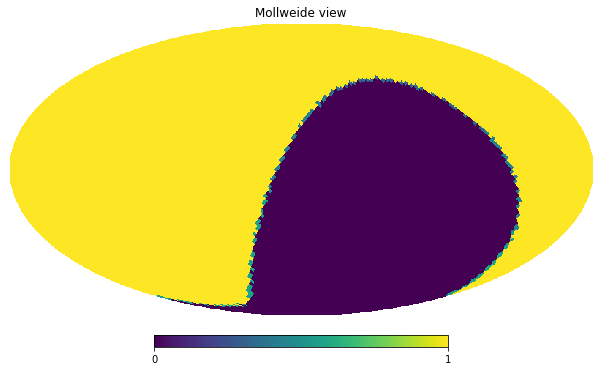

In [63]:
hp.mollview(cbass_mask_G)

In [67]:
spass_mask = np.ones(12*1024**2)
spass_mask[np.where(spass_noise_map < 0)] = 0
spass_mask = hp.ud_grade(spass_mask, nside_out = 32)

Multiprocessing took 1.23 mins


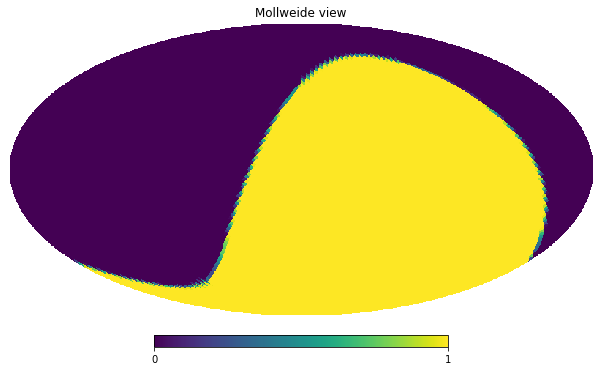

In [68]:
hp.mollview(spass_mask)

## overlapping region

In [77]:
sum(spass_mask*cbass_mask_G)/(12*Nside**2)

0.12667528788248697

In [80]:
mask_both = spass_mask*cbass_mask_G
mask_both[mask_both != 0] = 1

In [82]:
sum(mask_both)

1755.0

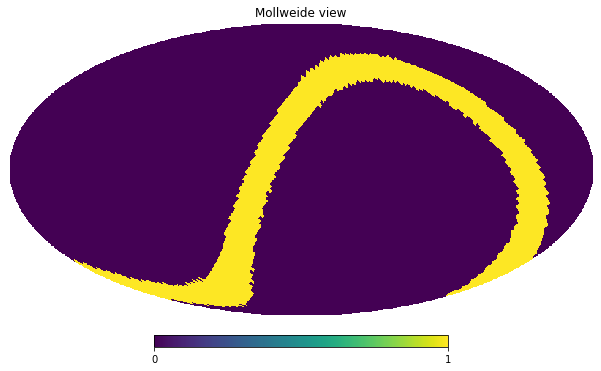

In [81]:
hp.mollview(mask_both)

In [83]:
np.save('/global/cscratch1/sd/jianyao/CBASS/mask_both_32.npy', mask_both)

In [86]:
index = np.arange(12*Nside**2)
masked_index = index[mask_both == 1]

In [87]:
np.save('/global/cscratch1/sd/jianyao/CBASS/masked_index.npy', masked_index)

In [94]:
masked_index

array([  744,   745,   746, ..., 12154, 12155, 12156])

In [97]:
len(masked_index)

1755

## Typical sensitivity for SPASS CBASS K Ka 30 in $\mu K \_ RJ$

- SPASS 0.815 mk - 8.9arcmin -- 92 uK arcmin ; QU
- CBASS 0.30mk - 1 deg -- 5 $\mu K\_RJ$ arcmin; I
- WMAP K 7.7 uK - 1 deg -- 0.128 uK_RJ arcmin; I
- Planck 30 1.1 uk - 1deg -- 0.018 uK_RJ arcmin; I 

- S-PASS sensitivity in uK_thermo amin: 8070
- C-BASS sensitivity in uK_thermo amin: 4500
- WMAP-K sensitivity in uK_thermo amin: 435
- WMAP-Ka sensitivity in uK_thermo amin: 436
- Planck-30 sensitivity in uK_termo amin: 276

In [19]:
fres

array([ 2.3,  5. , 23. , 28.4, 33. ])

In [7]:
## from sigma_I to sigma_Q and sigma_U
# Sens_P = np.array((92, 5*np.sqrt(2), 0.128*np.sqrt(2), 0.128*np.sqrt(2), 0.018*np.sqrt(2)))

Sens_P_CMB = np.array((8070, 4500, 435, 276, 436))

## transform form $\mu K \_ CMB$ to $\mu K \_RJ$

In [8]:
Sens_P_RJ = Sens_P_CMB*convert_units("uK_CMB", "uK_RJ", fres)

In [9]:
Sens_P_RJ

array([8068.89702552, 4497.09426442,  429.10255891,  270.31923344,
        423.93603191])

## $\sigma$ map in CMB units for Q and U

In [10]:
npix = 12*Nside**2
pix_amin2 = 4. * np.pi / float(npix) * (180. * 60. / np.pi) ** 2 
sigma_pix_P = np.sqrt(Sens_P_RJ ** 2 / pix_amin2)
sigma_pix_I = sigma_pix_P

In [11]:
sigma_pix_P

array([73.39660293, 40.90663706,  3.90321875,  2.45888792,  3.85622279])

### Assume $\sigma_P = \sigma_Q = \sigma_U ???? $Would this be wrong?

In [12]:
sig_maps = np.ones((len(Sens_P_RJ),npix))
sig_maps *= sigma_pix_P[:, None]

In [13]:
sig_maps

array([[73.39660293, 73.39660293, 73.39660293, ..., 73.39660293,
        73.39660293, 73.39660293],
       [40.90663706, 40.90663706, 40.90663706, ..., 40.90663706,
        40.90663706, 40.90663706],
       [ 3.90321875,  3.90321875,  3.90321875, ...,  3.90321875,
         3.90321875,  3.90321875],
       [ 2.45888792,  2.45888792,  2.45888792, ...,  2.45888792,
         2.45888792,  2.45888792],
       [ 3.85622279,  3.85622279,  3.85622279, ...,  3.85622279,
         3.85622279,  3.85622279]])

In [29]:
np.save('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_sigma_P_%s_uK_RJ.npy'%Nside, sig_maps)

## from $\sigma$ to pixel realizations, add noise to signal and get $P = \sqrt{Q^2 + U^2}$

In [54]:
print('5_fre_noise_%03d.npy'%10)

5_fre_noise_010.npy


In [15]:
np.arange(10,50)

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49])

In [16]:
Nsamp = 100

for i in np.arange(10,50):
    noise = np.random.randn(len(Sens_P_RJ), 3, npix)
    noise[:, 0, :] *= sigma_pix_I[:, None]
    noise[:, 1, :] *= sigma_pix_P[:, None]
    noise[:, 2, :] *= sigma_pix_P[:, None]
    np.save('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_noise_%s_uK_RJ_%03d.npy'%(Nside, i), noise)
    
    total = maps_RJ + noise  ## add noise realization to signals (only synchrontron)
    total_QU = np.ones((len(fres), 12*Nside**2))
    for fre in range(len(fres)):

        total_QU[fre] = np.sqrt((total[fre][1])**2 + (total[fre][2])**2) 
        np.save('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/totalP_s0_%s_uK_RJ_%03d.npy'%(Nside,i), total_QU)
    

## also Q and U maps for fgbuster

In [17]:
for i in np.arange(10,50):
    noise = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_noise_%s_uK_RJ_%03d.npy'%(Nside, i))
    total = maps_RJ + noise
    
    np.save('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/total_IQU_s0_%s_uK_RJ_%03d.npy'%(Nside,i), total)

In [10]:
maps_RJ.shape

(5, 3, 12288)

In [8]:
noise.shape

(5, 3, 12288)

In [31]:
# plt.figure(figsize = (10,8))
# hp.mollview(noise[0][1], sub = (3,4,1))
# hp.mollview(noise[0][2], sub = (3,4,2))

# hp.mollview(noise[1][1], sub = (3,4,3))
# hp.mollview(noise[1][2], sub = (3,4,4))

# hp.mollview(noise[2][1], sub = (3,4,5))
# hp.mollview(noise[2][2], sub = (3,4,6))

# hp.mollview(noise[3][1], sub = (3,4,7))
# hp.mollview(noise[3][2], sub = (3,4,8))

# hp.mollview(noise[4][1], sub = (3,4,9))
# hp.mollview(noise[4][2], sub = (3,4,10))

# Power spectrum of noise and signal

In [4]:
noise_CMB = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_noise_000.npy')
signal = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/5_fre_d0s0_128_uK_CMB.npy') # synchrotron + dust

In [5]:
noise_CMB.shape

(5, 3, 196608)

In [6]:
signal.shape

(5, 3, 196608)

In [7]:
nl = hp.anafast(noise_CMB[0])
cl = hp.anafast(signal[0])

In [ ]:
ell = np.arange(len(nl))